# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

In [3]:
model_ppc=CmdStanModel(stan_file='stan_files/height_1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [4]:
R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [5]:
sim_draws = sim.draws_pd()
sim.draws_pd() # Im not sure why these values are so low, but they become much more reasonable when we remove most of sampling params.

,lp__,accept_stat__,mu,sigma,height
0,0.0,0.0,188.541,16.5544,167.479
1,0.0,0.0,175.638,12.2212,178.646
2,0.0,0.0,180.994,19.5307,199.955
3,0.0,0.0,177.777,16.1979,177.420
4,0.0,0.0,181.560,14.3157,177.106
...,...,...,...,...,...
995,0.0,0.0,174.864,16.0423,187.452
996,0.0,0.0,172.970,12.6132,176.423
997,0.0,0.0,171.817,14.7975,172.871
998,0.0,0.0,175.046,15.4959,151.389


4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

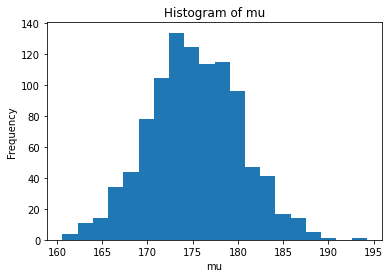

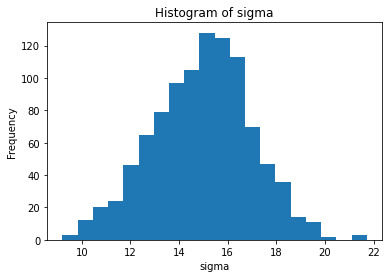

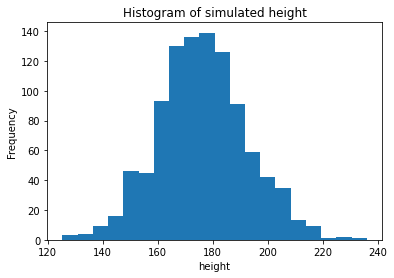

In [6]:
# 1. Plot histograms of mu, sigma and simulated height.

plt.hist(sim_draws['mu'], bins=20) # Since we're using fixed params, nothing interesting will be displayed here.
plt.title("Histogram of mu")
plt.xlabel("mu")
plt.ylabel("Frequency")
plt.show()

plt.hist(sim_draws['sigma'], bins=20) # Since we're using fixed params, nothing interesting will be displayed here.
plt.title("Histogram of sigma")
plt.xlabel("sigma")
plt.ylabel("Frequency")
plt.show()

plt.hist(sim_draws['height'], bins=20)
plt.title("Histogram of simulated height")
plt.xlabel("height")
plt.ylabel("Frequency")
plt.show()

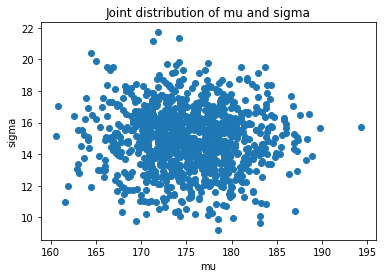

In [7]:
# 2. Plot a joint distribution of mu and sigma.

plt.scatter(sim_draws['mu'], sim_draws['sigma'])
plt.title("Joint distribution of mu and sigma")
plt.xlabel("mu")
plt.ylabel("sigma")
plt.show()

In [8]:
# 3. Check if samples are consistent with priors.
import numpy as np
from scipy.stats import norm

x = np.linspace(100, 240, 1000)
x2 = np.linspace(0, 30, 1000)

prior_mu = loc=sim_draws['mu'].mean()
prior_sigma = loc=sim_draws['sigma'].mean()
sample_mu = loc=sim_draws['height'].mean()
sample_sigma = sim_draws['height'].std()

print(f"Prior ~ normal({prior_mu}, {prior_sigma}). Sample distribution ~ normal({sample_mu, sample_sigma})")


Prior ~ normal(175.191754, 14.963684010000001). Sample distribution ~ normal((176.25803900000002, 16.216559043727425))


## Task 2. Model fit and evaluation

In [9]:
model_1_fit=CmdStanModel(stan_file='stan_files/height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [10]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [11]:
fit_draws = fit.draws_pd()
fit.draws_pd()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,height
0,-908.832,0.675340,0.889568,2.0,3.0,0.0,915.553,155.025,7.89278,157.977
1,-909.543,0.903799,0.889568,2.0,3.0,0.0,909.869,155.154,8.22353,154.880
2,-911.191,0.709979,0.889568,2.0,3.0,0.0,912.438,155.363,7.43941,160.444
3,-910.685,1.000000,0.889568,1.0,1.0,0.0,911.451,155.329,7.50323,148.312
4,-910.710,0.967872,0.889568,2.0,3.0,0.0,911.740,153.883,8.00773,163.090
...,...,...,...,...,...,...,...,...,...,...
3995,-908.906,1.000000,0.687296,2.0,3.0,0.0,910.158,155.052,7.99087,151.740
3996,-909.190,0.985517,0.687296,2.0,7.0,0.0,909.376,154.889,8.22998,142.302
3997,-910.362,0.928027,0.687296,2.0,3.0,0.0,910.472,155.142,8.44015,164.533
3998,-910.466,0.947806,0.687296,3.0,7.0,0.0,912.328,154.108,7.56298,168.597



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


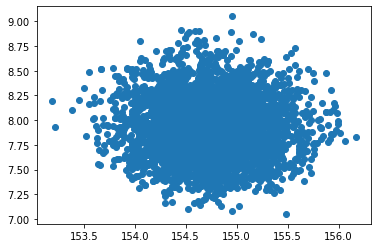

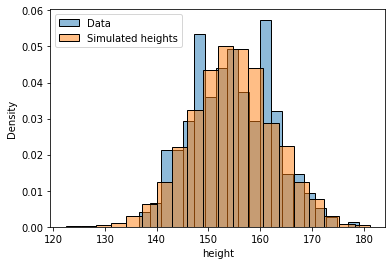

In [12]:

import seaborn as sns

# Plot a joint distribution of fitted mu and sigma
plt.scatter(fit_draws["mu"], fit_draws["sigma"])
plt.show()
# Plot histograms of data and simulated heights
simulated_heights = fit_draws["height"]
sns.histplot(d.height.values, bins=20, stat="density", alpha=.5, label="Data")
sns.histplot(simulated_heights, bins=20, stat="density", alpha=.5, label="Simulated heights")
plt.legend()
plt.show()

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [13]:
print(d)

d['c_weight'] = d['height'] - d['height'].mean()
data_sim={'N':50, 'weight': d['weight']}

      height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041914  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
534  162.560  47.031821  27.0     0
537  142.875  34.246196  31.0     0
540  162.560  52.163080  31.0     1
541  156.210  54.062497  21.0     0
543  158.750  52.531624  68.0     1

[352 rows x 4 columns]


In [14]:
d

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,-2.832093
1,139.700,36.485807,63.0,0,-14.897093
2,136.525,31.864838,65.0,0,-18.072093
3,156.845,53.041914,41.0,1,2.247907
4,145.415,41.276872,51.0,0,-9.182093
...,...,...,...,...,...
534,162.560,47.031821,27.0,0,7.962907
537,142.875,34.246196,31.0,0,-11.722093
540,162.560,52.163080,31.0,1,7.962907
541,156.210,54.062497,21.0,0,1.612907


## Task 4. Prior predictive checks
 

In [15]:
model_ppc=CmdStanModel(stan_file='stan_files/height_2a_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [16]:
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     chains=1)
sim.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 StatusERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


RuntimeError: Error during sampling:
Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=weight; position=0; dims declared=(50); dims found=(352) (in '/root/docs/data_analytics_2023_hszwast/lab_4/stan_files/height_2a_ppc.stan', line 3, column 2 to column 17)Command and output files:
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/root/docs/data_analytics_2023_hszwast/lab_4/stan_files/height_2a_ppc', 'id=1', 'random', 'seed=40322', 'data', 'file=/tmp/tmp6kqdd909/wdqxd7u1.json', 'output', 'file=/tmp/tmp6kqdd909/height_2a_ppc-20230420090509.csv', 'method=sample', 'num_samples=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp6kqdd909/height_2a_ppc-20230420090509.csv
 console_msgs (if any):
	/tmp/tmp6kqdd909/height_2a_ppc-20230420090509_0-stdout.txt

Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

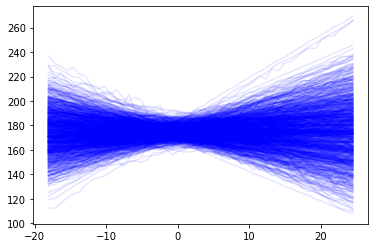

In [ ]:
def plot_lines(draws_df, x, n_params, **kwargs):
    for i in range(len(draws_df)):
        y_ = [val for _, val in draws_df.iloc[i][n_params:].items()]
        plt.plot(x, y_, **kwargs)
    plt.show()

plot_lines(sim.draws_pd(), data_sim['weight'], n_params=10, alpha=.1, color='blue')

## These height values can be observed in natural world


## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [ ]:
model_ppc=CmdStanModel(stan_file='stan_files/height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file /root/docs/data_analytics_2023_hszwast/lab_4/stan_files/height_2b_ppc.stan to exe file /root/docs/data_analytics_2023_hszwast/lab_4/stan_files/height_2b_ppc
INFO:cmdstanpy:compiled model executable: /root/docs/data_analytics_2023_hszwast/lab_4/stan_files/height_2b_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/docs/data_analytics_2023_hszwast/lab_4/stan_files/height_2b_ppc.hpp /root/docs/data_analytics_2023_hszwast/lab_4/stan_files/height_2b_ppc.stan
Warning in '/root/docs/data_analytics_2023_hszwast/lab_4/stan_files/height_2b_ppc.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/root/docs/data_analytics_2023_hszwast/lab_4/stan_files/height_2b_ppc.stan', line 19, column 2: Declaration
    of arrays b

In [ ]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     chains=1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [ ]:
sim.draws_pd()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,-2.91854,0.491197,0.057655,5.0,47.0,0.0,4.84379,167.819,1.347080,1.373400,...,190.451,188.614,192.942,195.364,195.717,198.110,200.027,202.785,199.105,202.738
1,-2.88690,0.972222,0.057655,5.0,36.0,1.0,4.41304,173.453,2.522500,0.753713,...,215.992,216.731,218.987,221.683,224.701,226.200,229.123,229.695,233.308,234.611
2,-2.68445,0.999709,0.057655,4.0,31.0,0.0,3.90549,174.727,2.396340,1.091840,...,216.103,215.271,218.163,220.183,221.356,227.692,227.001,226.120,230.508,233.036
3,-2.70929,0.961500,0.057655,4.0,23.0,0.0,3.07286,175.568,2.430700,1.035940,...,217.026,216.870,220.512,223.424,224.307,226.338,229.407,232.477,233.434,233.863
4,-3.35019,0.966877,0.057655,4.0,29.0,0.0,3.56991,174.468,2.951160,1.544240,...,221.674,227.342,228.574,229.806,233.587,233.940,240.993,240.038,242.808,246.358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.60406,0.749786,0.057655,2.0,4.0,1.0,5.10690,173.963,0.308136,0.335692,...,179.002,179.557,179.837,179.123,180.128,180.195,180.588,180.704,181.438,181.537
996,-2.13359,0.999849,0.057655,5.0,63.0,0.0,3.16725,177.490,0.427865,0.210771,...,184.451,184.992,185.408,185.429,185.931,186.865,186.872,187.016,187.863,188.061
997,-1.77982,0.998192,0.057655,5.0,63.0,0.0,2.57403,178.193,0.359662,0.332377,...,183.850,184.274,184.904,185.188,185.013,186.763,186.262,186.709,187.069,187.044
998,-1.86157,0.995453,0.057655,6.0,63.0,0.0,3.20398,175.504,0.538546,0.264491,...,184.887,185.002,185.599,186.075,186.533,186.590,186.726,188.123,188.170,188.421


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

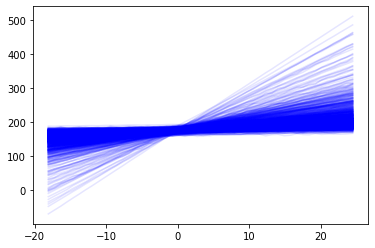

In [ ]:
# Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
plot_lines(sim.draws_pd(), data_sim['weight'], n_params=10, alpha=.1, color='blue')

[-18.07209261 -17.20382731 -16.335562   -15.4672967  -14.59903139
 -13.73076608 -12.86250078 -11.99423547 -11.12597016 -10.25770486
  -9.38943955  -8.52117425  -7.65290894  -6.78464363  -5.91637833
  -5.04811302  -4.17984772  -3.31158241  -2.4433171   -1.5750518
  -0.70678649   0.16147881   1.02974412   1.89800943   2.76627473
   3.63454004   4.50280535   5.37107065   6.23933596   7.10760126
   7.97586657   8.84413188   9.71239718  10.58066249  11.44892779
  12.3171931   13.18545841  14.05372371  14.92198902  15.79025433
  16.65851963  17.52678494  18.39505024  19.26331555  20.13158086
  20.99984616  21.86811147  22.73637677  23.60464208  24.47290739]


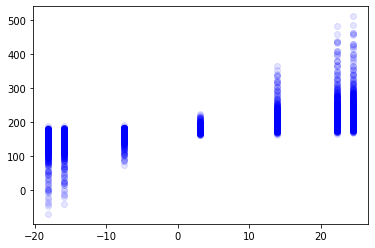

In [ ]:
# For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?
def plot_quantiles(draws_df, x, n_params, **kwargs):
    for i in range(len(draws_df)):
        y_ = [val for _, val in draws_df.iloc[i][n_params:].items()]
        x_quantile = np.quantile(x, [0, .05, .25, .5, .75, .95, 1])
        y_quantile = np.quantile(y_, [0, .05, .25, .5, .75, .95, 1])
        plt.scatter(x_quantile, y_quantile, **kwargs)
    plt.show()
plot_quantiles(sim.draws_pd(), data_sim['weight'], n_params=10, alpha=.1, color='blue')


## Task 6. Fitting and evaluating model


In [ ]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [ ]:
data_fit = {'N': 50, 'weight': d.c_weight.values[:50], 'height': d.height.values[:50]} 

fit=model_2_fit.sample(data=data_fit,seed=28052020)


NameError: name 'model_2_fit' is not defined

2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 